# CQF - Exam 2

### Imports

In [2]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1

Parameters

In [3]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 200
dt = T / N
ts = np.arange(0, T, dt)
dB = np.random.randn(N) * np.sqrt(dt)
B = np.cumsum(dB)

### Euler-Maruyama scheme

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B
$$

<AxesSubplot:>

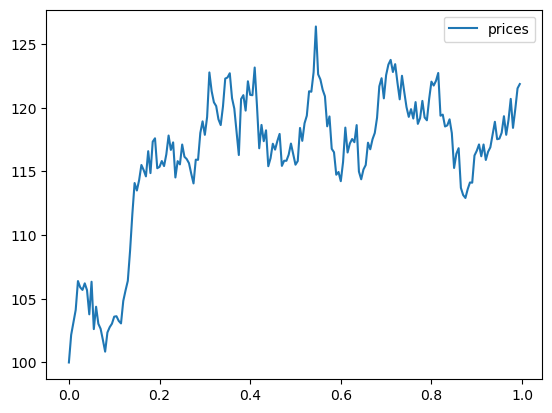

In [4]:
S = np.zeros(len(ts))
S[0] = S0

for i in range(1, len(ts)):
    S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i]

em_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
em_df.plot()

### Milstein schema

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B + \frac{1}{2}\sigma^{2} S_{n} (\Delta B^{2} - \Delta t)
$$

<AxesSubplot:>

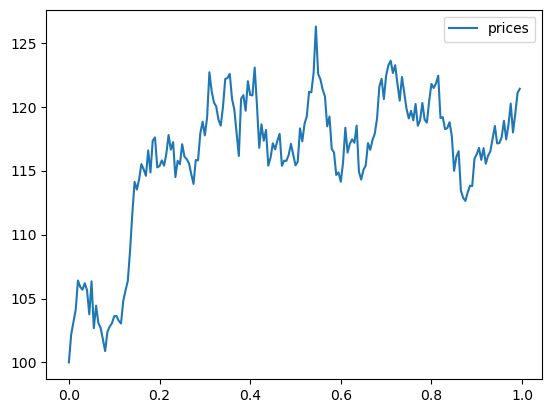

In [5]:
S = np.zeros(len(ts))
S[0] = S0

for i in range(1, len(ts)):
    S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i] \
        + 0.5*(sigma**2)*S[i-1]*(dB[i]**2-dt)

milstein_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
milstein_df.plot()

### Closed Form Solution

$$
S_{n+1} = S_{n}\exp{((r-\frac{\sigma^2}{2})t + \sigma B(t))}
$$

<AxesSubplot:>

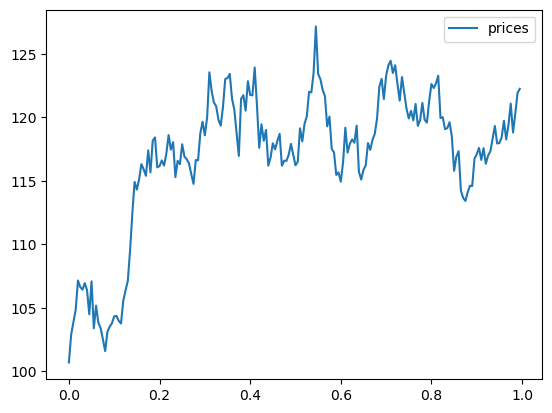

In [6]:
S = S0 * np.exp((r-0.5*sigma**2)*ts + sigma*B)
closed_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
closed_df.plot()

<AxesSubplot:>

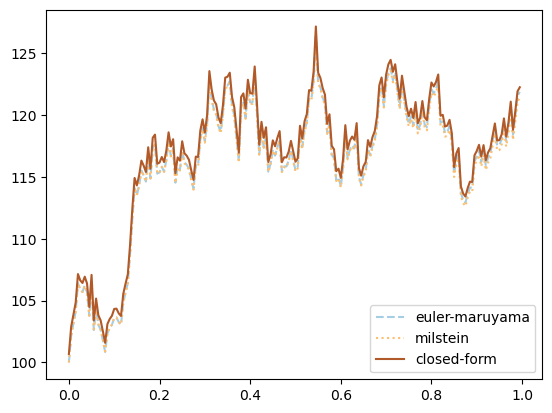

In [7]:
compare_df = em_df.copy()
compare_df.columns = ['euler-maruyama']

compare_df['milstein'] = milstein_df['prices']
compare_df['closed-form'] = closed_df['prices']
compare_df.plot(style=['--', ':', '-'],colormap='Paired')

### Question 3 - Monte Carlo Integration

Define function for Monte Carlo integration

In [8]:
def monte_carlo_integration(func, N, limit_inf, limit_sup):
    xs = np.random.uniform(limit_inf, limit_sup, size=N)
    ys = [func(x) for x in xs]
    return (limit_sup - limit_inf) / N * np.sum(ys)

I.
$$
\int_{1}^{3}x^2dx = \frac{1}{3}x^3\Biggr|_{1}^{3} =  \frac{26}{3} = 8.666667
$$

In [64]:
def func(x):
    return x**2

exact_value = 8.666667
limit_inf = 1
limit_sup = 3

In [65]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920, 163840, 327680]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,8.666667,9.614810,-0.948143
20,8.666667,8.703844,-0.037177
40,8.666667,9.495301,-0.828634
80,8.666667,7.905635,0.761032
160,8.666667,8.586028,0.080639
320,8.666667,9.038057,-0.371390
640,8.666667,8.839121,-0.172454
1280,8.666667,8.726455,-0.059788
2560,8.666667,8.695698,-0.029031
5120,8.666667,8.581539,0.085128


Text(0, 0.5, 'error')

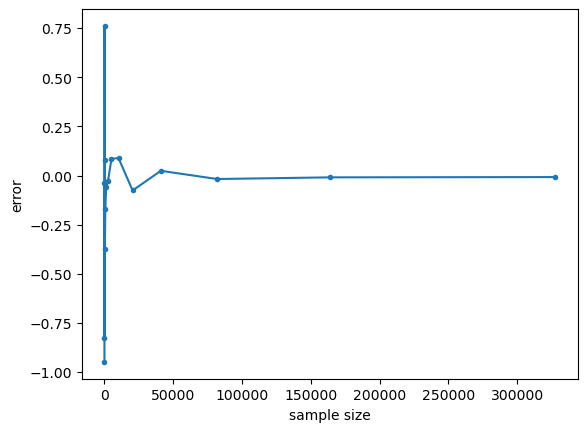

In [66]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')

II.
$$
\int_{0}^{\infty}e^{-x^2}dx = \frac{1}{2}\sqrt\pi \text{erf} (x) \approx 0.886227
$$

In [73]:
def func(x):
    return np.exp(-x**2)

exact_value = 0.886227
limit_inf = 0
limit_sup = 500

In [74]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920, 163840, 327680]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,0.886227,0.000000e+00,0.886227
20,0.886227,1.017382e-101,0.886227
40,0.886227,9.753709e-265,0.886227
80,0.886227,1.881684e-04,0.886039
160,0.886227,2.021902e-01,0.684037
320,0.886227,1.174664e+00,-0.288437
640,0.886227,7.851220e-01,0.101105
1280,0.886227,1.333041e+00,-0.446814
2560,0.886227,6.127490e-01,0.273478
5120,0.886227,8.027067e-01,0.083520


Text(0, 0.5, 'error')

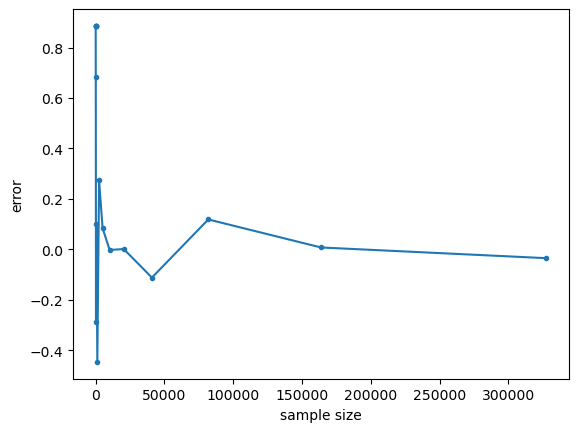

In [75]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')

III.

$$
\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}x^{4}e^{-x^2/2}dx = 0.398942 \left( 3\sqrt{\frac{\pi}{2}} \text{erf} \left(\frac{x}{\sqrt{2}}\right) - e^{-x^2/2} x ( x^2 + 3) \right) = 3
$$

In [76]:
def func(x):
    return ( 1.0 / np.sqrt(2*np.pi) ) * x**4 * np.exp(-x**2 / 2)

exact_value = 3.
limit_inf = -500
limit_sup = 500

In [77]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920, 163840, 327680]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,3.0,4.915361e+01,-46.153614
20,3.0,7.358982e-55,3.000000
40,3.0,2.106291e+01,-18.062909
80,3.0,1.505505e+00,1.494495
160,3.0,1.097595e-02,2.989024
320,3.0,1.697491e+00,1.302509
640,3.0,1.353283e+00,1.646717
1280,3.0,2.851968e+00,0.148032
2560,3.0,3.758549e+00,-0.758549
5120,3.0,3.413088e+00,-0.413088


Text(0, 0.5, 'error')

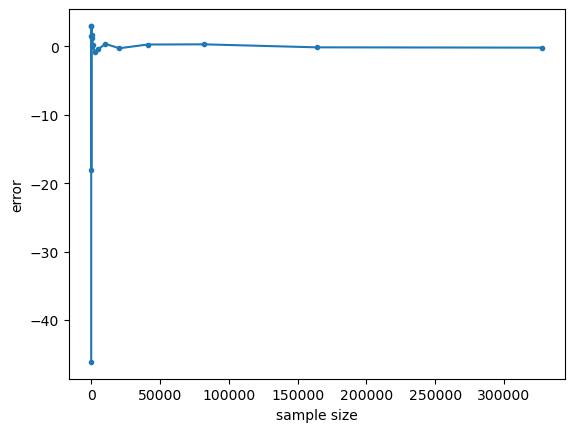

In [78]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')